In [1]:
from copy import deepcopy
from collections import Counter
import pickle, re, math, string, glob, time, uuid, json, os

from tqdm import tqdm
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_styles import *

from bs4 import BeautifulSoup as BS
from rank_bm25 import BM25Okapi
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
from spacy.lang.en.stop_words import STOP_WORDS

def show_sample(d):
    for k, v in d.items():
        print('{}: {}'.format(k, v))

[nltk_data] Downloading package punkt to /home/dojo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dojo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Import Combined Dataset from `get-wiki-data.ipynb`

In [2]:
PATH = 'data'
if not os.path.exists(PATH):
    os.makedirs(PATH)
    os.makedirs(PATH + '/raw_data')
    os.makedirs(PATH + '/preprocessed')

In [3]:
# The below needs to be downloaded - instructions in README.md
raw_df = pd.read_pickle(PATH + '/raw_data/combined-dataset.pkl')

In [4]:
raw_df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean ans,wiki,q_cleaned
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,Copernicus,Nicolaus Copernicus (; Polish: Mikołaj Koperni...,0
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,Jim Thorpe,James Francis Thorpe (Sac and Fox (Sauk): Wa-T...,0
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,Arizona,Arizona ( (listen) ARR-iz-OH-nə; Navajo: Hoozd...,0
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,McDonald's,McDonald's Corporation is an American fast foo...,0
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,John Adams,"John Adams Jr. (October 30, 1735 – July 4, 182...",0


# Extract relevant passages from wiki

In [5]:
def sent_tokenize(text):
    sentences = re.split(r"[.!?]", text)
    sentences = [sent.strip(" ") for sent in sentences]
    return sentences

def pre_processing(collection):
    collection = collection.lower()
    collection = collection.translate(str.maketrans('','',string.punctuation))
    collection = re.sub(r'\d+', '', collection)
    collection = collection.strip()

    lemmatizer=WordNetLemmatizer()
    collection=word_tokenize(collection)
    
    collection_clean = []
    for word in collection:
        collection_clean.append(lemmatizer.lemmatize(word))
        
    stop_words = set(STOP_WORDS)
    collection_clean = [i for i in collection_clean if not i in stop_words]
    
    return collection_clean

In [6]:
clues = []
responses = []
categories = []
scores_bm25 =[]
passages = []

for index, row in tqdm(raw_df.iterrows(), total=raw_df.shape[0]):
    query = row[' Question'] + ' ' + row[' Answer']
    passage_ss = sent_tokenize(row['wiki'])
    
    tokenized_corpus = [pre_processing(doc) for doc in passage_ss]
    bm25 = BM25Okapi(tokenized_corpus)
    tokenized_query = pre_processing(query)
    doc_scores = bm25.get_scores(tokenized_query)
    
    score_argmax = np.argmax(doc_scores)
    if score_argmax == 0:
        best_sentences = passage_ss[:score_argmax + 3]
    elif score_argmax == len(passage_ss) - 1:
        best_sentences = passage_ss[score_argmax - 3:]
    else:
        best_sentences = passage_ss[score_argmax - 1:score_argmax + 2]
    
    responses.append(row[' Answer'])
    clues.append(row[' Question'])
    categories.append(row[' Category'])
    passages.append('. '.join(best_sentences).replace('\n', ' ').replace('\'"', '"'))
    scores_bm25.append(doc_scores[score_argmax])

data_raw = {
    'clues': clues,
    'responses': responses,
    'categories': categories,
    'scores_bm25': scores_bm25,
    'passages': passages 
}

 49%|████▊     | 72398/149006 [1:26:32<1:29:54, 14.20it/s]IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 149006/149006 [2:58:25<00:00, 13.92it/s]  


In [7]:
pickle.dump(data_raw, open(PATH + '/raw_data/data-w-scores.pkl', 'wb'))

In [8]:
data_raw = pickle.load(open(PATH + '/raw_data/data-w-scores.pkl', 'rb'))

## See Example Datapoint

In [9]:
data_raw['clues'][28]

'<a href="http://www.j-archive.com/media/2004-12-31_DJ_26.mp3">Ripped from today\'s headlines, he was a turtle king gone mad; Mack was the one good turtle who\'d bring him down</a>'

## Preprocess `<a>` tags

In [10]:
data_notags = deepcopy(data_raw)
count = 0
idxs = []
for i in tqdm(range(len(data_notags['passages']))):
    if '://' in data_notags['passages'][i]:
        count += 1
        data_notags['passages'][i] = BS(data_notags['passages'][i], 'html.parser').get_text()
    if '://' in data_notags['clues'][i]:
        count += 1
        data_notags['clues'][i] = BS(data_notags['clues'][i], 'html.parser').get_text()
count

100%|██████████| 149006/149006 [00:01<00:00, 145345.36it/s]


7305

In [11]:
data_notags['clues'][28]

"Ripped from today's headlines, he was a turtle king gone mad; Mack was the one good turtle who'd bring him down"

## Remove Oddly formatted links

In [12]:
data_notags['passages'][13090]

'is/20131116140756/https://sites. google. com/site/levistraussfamily/ Biography of Levi Strauss from the Official Levi Strauss Site.  Levi Strauss at Find a Grave Levi Strauss Museum in Buttenheim, Germany (in German) Levi Strauss at FMD'

In [13]:
count = 0
naughty_idxs = []
for i in tqdm(range(len(data_notags['passages']))):
    if '://' in data_notags['passages'][i] or '://' in data_notags['clues'][i]:
        count += 1
        naughty_idxs.append(i)

100%|██████████| 149006/149006 [00:00<00:00, 1151357.57it/s]


In [14]:
print('found {} bad samples'.format(count))

found 27 bad samples


In [15]:
# form dataframe
df_notags = pd.DataFrame(data_notags)
old_length = len(df_notags)
print('currently have {} samples'.format(old_length))

currently have 149006 samples


Show bad examples

In [16]:
df_notags.iloc[naughty_idxs][['clues', 'passages']]

,clues,passages
348,"Movie in which Axel Foley asks, ""where ...you ...","On November 14, 2019, Deadline Hollywood annou..."
5075,"Formed by plate tectonics, these mid-ocean upl...",An Ice pressure ridge develops in an ice cover...
9227,http://www.j-archive.com/Read all about me at ...,The slash is an oblique slanting line punctuat...
13090,The logo seen here has identified this brand s...,is/20131116140756/https://sites. google. com/s...
16359,The seat of Montana State University is named ...,Archives John M. Bozeman's papers are now he...
31351,"Plate armor first covered, then replaced this ...",com/patterns/european/index. html http://www. ...
33489,Joely Richardson starred as Marie Antoinette i...,in both instances. References External links...
38619,"Popular during Christmas, he's the holy man et...",Saint Nicholas Center: Who is Saint Nicholas....
49539,"Forever, or a fragrance by Calvin Klein","The circle, band or ring is also commonly used..."
57957,This fictional rural girl charms a businessman...,Shirley Temple played Rebecca in the more free...


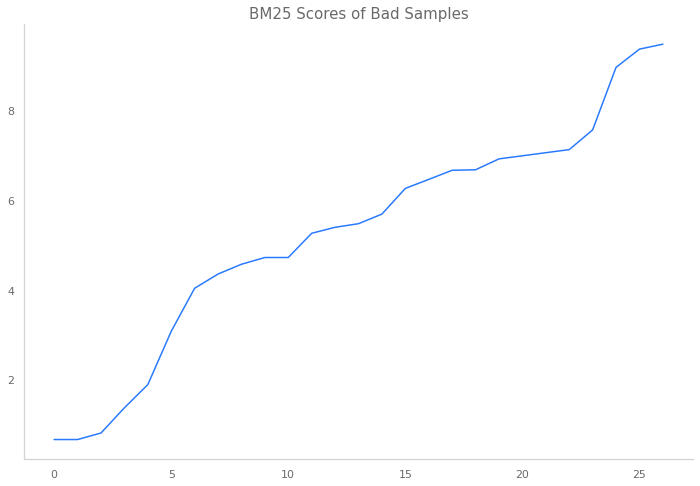

In [17]:
scores_naughty = np.array(data_notags['scores_bm25'])[naughty_idxs]
scores_naughty.sort()
plt.title('BM25 Scores of Bad Samples')
plt.plot(scores_naughty);

Nothing above bm25 score of 10, hence we can drop them.

In [18]:
df_nourls = df_notags.drop(idxs).reset_index(drop=True)
df_nourls

,clues,responses,categories,scores_bm25,passages
0,"For the last 8 years of his life, Galileo was ...",Copernicus,HISTORY,15.476244,"The corrections to De revolutionibus, which om..."
1,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,ESPN's TOP 10 ALL-TIME ATHLETES,10.516087,"Baseball, football, and other sports Thorpe ..."
2,The city of Yuma in this state has a record av...,Arizona,EVERYBODY TALKS ABOUT IT...,10.246053,"In the state's urban centers, the effects of l..."
3,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,THE COMPANY LINE,5.412499,McDonald's has taken to partnering up with Sin...
4,"Signer of the Dec. of Indep., framer of the Co...",John Adams,EPITAPHS & TRIBUTES,12.932640,Adams was the primary author of the Massachuse...
...,...,...,...,...,...
149001,"Shivers walking through 718 Fifth Ave., the je...",Harry Winston,SYMPTOMS OF AFFLUENZA,7.199821,in New York City in 1932. He had been called b...
149002,He came to America in 1847 to join his brother...,Levi Strauss,COMING TO AMERICA,7.131343,He was the son of Hirsch Strauss and his secon...
149003,This popular 1920s dance style was named for a...,the Charleston,SWEET CAROLINA,24.781041,The Charleston is a dance named after the harb...
149004,"In the fir tree, not flowers but these hold th...",cones,YOU DON'T BRING ME FLOWERS,1.667977,A cone with a polygonal base is called a pyram...


In [19]:
df_sorted = df_nourls.sort_values('scores_bm25', ascending=False).reset_index(drop=True)

# Perform Thresholding According to Article Relevance

In [20]:
THRESHOLD = 15

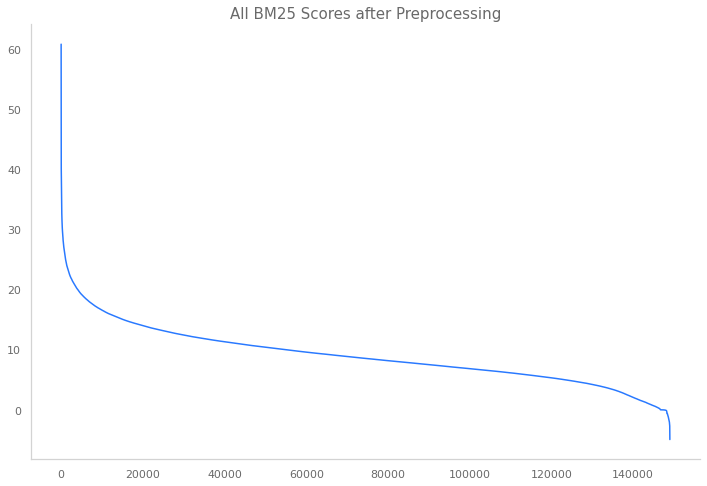

In [21]:
plt.title('All BM25 Scores after Preprocessing')
plt.plot(df_sorted['scores_bm25']);

In [22]:
df_sorted.to_pickle(PATH + '/preprocessed/all_data.pkl')

There are 15255 samples above 15


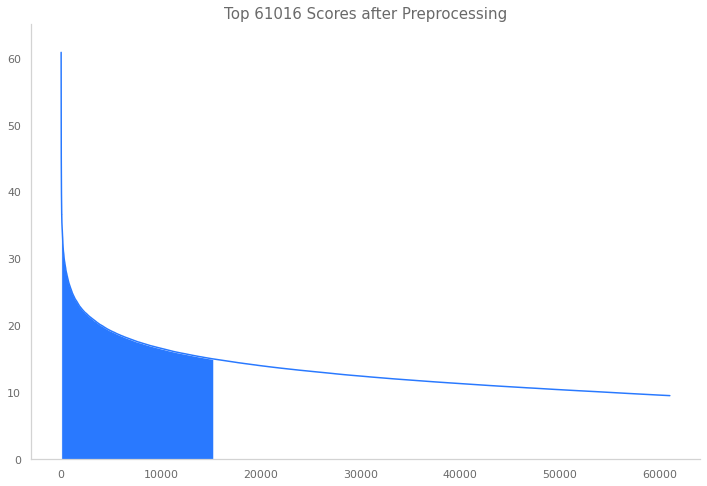

In [23]:
thres_idx = np.where(df_sorted['scores_bm25'] < THRESHOLD)[0][0]
plt.title('Top {} Scores after Preprocessing'.format(4*thres_idx))
plt.ylim([0, 65])
plt.fill_between(range(0, thres_idx), df_sorted['scores_bm25'][:thres_idx])
plt.plot(df_sorted['scores_bm25'][:4*thres_idx]);
print('There are {} samples above {}'.format(thres_idx+1, THRESHOLD))

The worst one within our threshold

In [24]:
show_sample(df_sorted.loc[thres_idx-1].to_dict())

clues: He was born in New York, & his howling early success was helped by his state-of-the-art Internet campaign
responses: Howard Dean
categories: DEMOCRATIC PRESIDENTIAL CONTENDERS 2004
scores_bm25: 15.0002695912265
passages: Dean endorsed Clinton over her competitor Senator Bernie Sanders in spite of the fact that Sanders represented the state of Vermont, where Dean had been governor.   Early life and education East Hampton and New York City childhood Dean was born in East Hampton, New York, to Andrée Belden (née Maitland), an art appraiser, and Howard Brush Dean, Jr. , an executive in the financial industry


## Cut off below the threshold above

In [25]:
df = df_sorted[df_sorted['scores_bm25'] > THRESHOLD]

In [26]:
df

,clues,responses,categories,scores_bm25,passages
0,"This leader said ""I have nothing to offer but ...",Winston Churchill,MISQUOTED,60.825823,". that I have nothing to offer but blood, toil..."
1,"Alexander Pope wrote the epitaph ""Nature and n...",Isaac Newton,FAMOUS SCIENTISTS,54.462345,After death Fame The mathematician Joseph-Lo...
2,"""In the jungle, welcome to the jungle, watch i...",Guns N' Roses,"JOHNNY GILBERT, ROCK GOD",51.487372,"Trying to put a scare into the young runaways,..."
3,"""In the souls of the people"" these ""are fillin...",The Grapes of Wrath,NOVEL TITLES,49.935663,The phrase also appears at the end of Chapter...
4,Kurt Cobain's suicide note quoted from this ma...,Neil Young,ROCK 'N' ROLL HISTORY,49.213770,"In 1994, Young again collaborated with Crazy..."
...,...,...,...,...,...
15249,"During this decades-long war, Sweden's King Gu...",the 30-Year War,HISTORIC NICKNAMES,15.001081,"A. Henty, The Lion of the North: The Adventure..."
15250,"On meeting this man, Paul asked to join his ba...",John Lennon,PAUL McCARTNEY,15.000332,Lennon first met Paul McCartney at the Quarrym...
15251,In 1791 John Rutledge left the U.S. Supreme Co...,South Carolina,PEOPLE IN HISTORY,15.000311,"In Texas vs. White (1869), the Supreme Court r..."
15252,"This man, already pronounced a heretic, was fo...",Martin Luther,WORMS,15.000286,"""Over the next five days, private conferences ..."


In [27]:
data_rows = [v for v in df.to_dict(orient='index').values()]

In [28]:
data_rows[:2]

[{'clues': 'This leader said "I have nothing to offer but blood, toil, tears & sweat", not "blood, sweat & tears"',
  'responses': 'Winston Churchill',
  'categories': 'MISQUOTED',
  'scores_bm25': 60.825823336033515,
  'passages': '. that I have nothing to offer but blood, toil, tears and sweat. We have before us an ordeal of the most grievous kind'},
 {'clues': 'Alexander Pope wrote the epitaph "Nature and nature\'s laws lay hid in night, God said, let" him "be and all was light"',
  'responses': 'Isaac Newton',
  'categories': 'FAMOUS SCIENTISTS',
  'scores_bm25': 54.46234466877474,
  'passages': '  After death Fame The mathematician Joseph-Louis Lagrange said that Newton was the greatest genius who ever lived, and once added that Newton was also "the most fortunate, for we cannot find more than once a system of the world to establish. " English poet Alexander Pope wrote the famous epitaph:  Nature and nature\'s laws lay hid in night; God said "Let Newton be" and all was light.  New

In [29]:
data_cols = df.to_dict(orient='list')

In [30]:
for k, v in data_cols.items(): print(k, v[:2])

clues ['This leader said "I have nothing to offer but blood, toil, tears & sweat", not "blood, sweat & tears"', 'Alexander Pope wrote the epitaph "Nature and nature\'s laws lay hid in night, God said, let" him "be and all was light"']
responses ['Winston Churchill', 'Isaac Newton']
categories ['MISQUOTED', 'FAMOUS SCIENTISTS']
scores_bm25 [60.825823336033515, 54.46234466877474]
passages ['. that I have nothing to offer but blood, toil, tears and sweat. We have before us an ordeal of the most grievous kind', '  After death Fame The mathematician Joseph-Louis Lagrange said that Newton was the greatest genius who ever lived, and once added that Newton was also "the most fortunate, for we cannot find more than once a system of the world to establish. " English poet Alexander Pope wrote the famous epitaph:  Nature and nature\'s laws lay hid in night; God said "Let Newton be" and all was light.  Newton was relatively modest about his achievements, writing in a letter to Robert Hooke in Febru

In [31]:
pickle.dump(data_cols, open(PATH + '/preprocessed/data_cols.pkl', 'wb'))
json.dump(data_rows, open(PATH + '/preprocessed/data_rows.json', 'w', encoding='utf-8'))

In [32]:
# data_list = []
# unique_cats = list(set(data['categories']))

# for cat in tqdm(unique_cats):
#     indices = [i for i, x in enumerate(data['categories']) if x == cat]

#     data_list.append({
#         "title": cat,
#         "paragraphs": [
#             {
#                 "context": data['passages'][i],
#                 "qas": [{
#                     "answers": [{
#                         "answer_start": 0,
#                         "text": data['responses'][i]
#                     }],
#                     "question": data['clues'][i],
#                     "id": uuid.uuid4().hex
#                 }]
#             } for i in indices
#         ]
#     })

# # main_json = {
# #     "root": {
# #         "data": data_list
# #     }
# # }
# # main_json

In [33]:
N = len(data_rows)
train_dev_idx = int(0.8 * N)
all_idxs = np.arange(N)
np.random.shuffle(all_idxs)
idxs_train = all_idxs[:train_dev_idx]
idxs_dev = all_idxs[train_dev_idx:]

data_arr = np.array(data_rows)
data_train = data_arr[idxs_train].tolist()
data_dev = data_arr[idxs_dev].tolist()

In [34]:
assert len(data_train) + len(data_dev) == len(data_rows), 'Data sizes do not match'

In [35]:
json.dump(data_train, open(PATH + '/preprocessed/data_train.json', 'w', encoding='utf-8'))
json.dump(data_dev, open(PATH + '/preprocessed/data_dev.json', 'w', encoding='utf-8'))